# Sign recognition: technologies we use



### Region-Convolutional Neural Network (R-CNN)



<img src="class.png" width="750" align="center">


### Architecture




<img src="net.png" width="750" align="center">



### End result


<img src="car.gif" width="750" align="center">
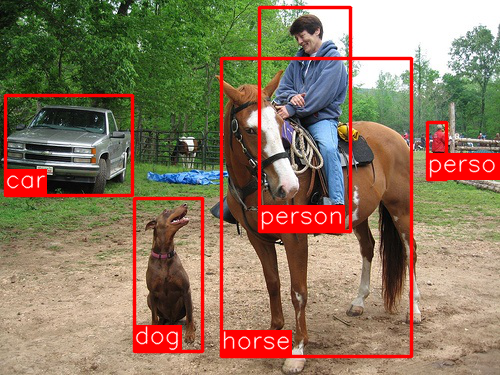
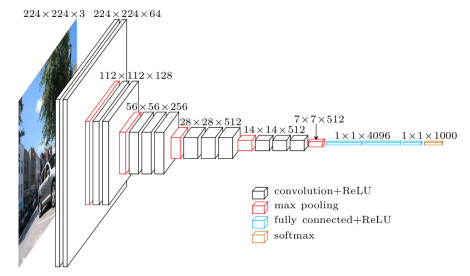

# 0. Create folders / download model (RUN ONCE)

## 0.1. Create TF records

In [2]:
!cd Tensorflow/models/research
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install --use-feature=2020-resolver .

zsh:1: no matches found: object_detection/protos/*.proto
cp: cannot stat 'object_detection/packages/tf2/setup.py': No such file or directory
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
You should consider upgrading via the '/home/mateo/.virtualenvs/ml39/bin/python -m pip install --upgrade pip' command.


## 0.2. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [ ]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

## 0.3. Copy Model Config to Training Folder

In [ ]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

In [ ]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 1. Setup new model

## 1.1. Setup Paths

In [1]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import cv2 
import numpy as np

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet_7_classes' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
CHECKPOINT = 'ckpt-11'
LABEL_MAP_NAME = CUSTOM_MODEL_NAME + '_label_map'

WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'

CHECKPOINT_PATH = MODEL_PATH+'/' + CUSTOM_MODEL_NAME +'/'
CONFIG_PATH =     MODEL_PATH+'/' + CUSTOM_MODEL_NAME +'/pipeline.config'

CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

## 1.2. Create Label Map

In [3]:
labels = [
    {'name':'hello', 'id':1}, 
    {'name':'no',    'id':2},
    {'name':'yes',   'id':3},
    {'name':'please',   'id':4},
    {'name':'thanks',   'id':5},
    {'name':'love_you',   'id':6},
    {'name':'play',   'id':7}
]

NUM_OF_CLASSES = len(labels)

with open(ANNOTATION_PATH + '\\' + LABEL_MAP_NAME + '.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [4]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/'+LABEL_MAP_NAME+'.pbtxt'} -o {ANNOTATION_PATH + '/' + CUSTOM_MODEL_NAME + '_train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/'+LABEL_MAP_NAME+'.pbtxt'} -o {ANNOTATION_PATH + '/' + CUSTOM_MODEL_NAME + '_test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/my_ssd_mobnet_7_classes_train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/my_ssd_mobnet_7_classes_test.record


## 1.3. Update Config For Transfer Learning

In [6]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [7]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [8]:
pipeline_config.model.ssd.num_classes = NUM_OF_CLASSES
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/'+PRETRAINED_MODEL_NAME+'/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/'+LABEL_MAP_NAME+'.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/' + CUSTOM_MODEL_NAME + '_train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH +'/'+LABEL_MAP_NAME+'.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/' + CUSTOM_MODEL_NAME + '_test.record']

In [9]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

## 1.4. Train the model

In [10]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=10000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet_7_classes --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet_7_classes/pipeline.config --num_train_steps=10000


# 3. Run

In [1]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet_7_classes' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
CHECKPOINT = 'ckpt-11'
LABEL_MAP_NAME = CUSTOM_MODEL_NAME + '_label_map'

WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'

CHECKPOINT_PATH = MODEL_PATH+'/' + CUSTOM_MODEL_NAME +'/'
CONFIG_PATH =     MODEL_PATH+'/' + CUSTOM_MODEL_NAME +'/pipeline.config'

CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [2]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import cv2 
import numpy as np

In [3]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

## 3.1. Load Model from Checkpoint

In [4]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, CHECKPOINT)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2022-02-28 00:43:04.832085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 00:43:05.033511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 00:43:05.033984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 00:43:05.035095: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 3.2. Detect in realtime

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH +'/'+LABEL_MAP_NAME+'.pbtxt')

In [6]:
category_index

{1: {'id': 1, 'name': 'hello'},
 2: {'id': 2, 'name': 'no'},
 3: {'id': 3, 'name': 'yes'},
 4: {'id': 4, 'name': 'please'},
 5: {'id': 5, 'name': 'thanks'},
 6: {'id': 6, 'name': 'love_you'},
 7: {'id': 7, 'name': 'play'}}

In [7]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

2022-02-28 00:43:55.532710: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-02-28 00:43:56.654779: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_ALLOC_FAILED
2022-02-28 00:43:56.655200: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_

NotFoundError: Graph execution error:

Detected at node 'ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2833, in run_cell
      result = self._run_cell(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2879, in _run_cell
      return runner(coro)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3280, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3340, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_161590/2002253749.py", line 11, in <cell line: 7>
      detections = detect_fn(input_tensor)
    File "/tmp/ipykernel_161590/3070481507.py", line 12, in detect_fn
      prediction_dict = detection_model.predict(image, shapes)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 569, in predict
      if self._feature_extractor.is_keras_model:
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 570, in predict
      feature_maps = self._feature_extractor(preprocessed_inputs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 251, in call
      return self._extract_features(inputs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/models/ssd_mobilenet_v2_fpn_keras_feature_extractor.py", line 219, in _extract_features
      image_features = self.classification_backbone(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D'
Detected at node 'ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2833, in run_cell
      result = self._run_cell(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2879, in _run_cell
      return runner(coro)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3280, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3340, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_161590/2002253749.py", line 11, in <cell line: 7>
      detections = detect_fn(input_tensor)
    File "/tmp/ipykernel_161590/3070481507.py", line 12, in detect_fn
      prediction_dict = detection_model.predict(image, shapes)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 569, in predict
      if self._feature_extractor.is_keras_model:
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 570, in predict
      feature_maps = self._feature_extractor(preprocessed_inputs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/meta_architectures/ssd_meta_arch.py", line 251, in call
      return self._extract_features(inputs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/object_detection/models/ssd_mobilenet_v2_fpn_keras_feature_extractor.py", line 219, in _extract_features
      image_features = self.classification_backbone(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/mateo/.virtualenvs/ml39/lib/python3.9/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D'
2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D}}]]
	 [[Postprocessor/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/unstack/_2]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node ssd_mobile_net_v2_fpn_keras_feature_extractor/model/Conv1/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_detect_fn_11997]